## Описание проекта

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей.  
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.  

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.  
В нашем распоряжении набор фотографий людей с указанием возраста.

# 1. Исследовательский анализ данных

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/.  
В нашем распоряжении одна папка со всеми изображениями (/final_files) и csv-файл labels.csv с двумя колонками: file_name и real_age.

Загрузим csv файл и фотографии из папки с изображениями.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50



labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


**Посмотрим на структуру csv Файла и количество объектов в нем**

In [2]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


В файле размеченная информация, в которой указан возраст, соответствующих человеку, изображенному на каждлй из фотографий.  
Два столбца - Название файла и Возраст. Размер выборки - 7591 запись.

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков нет, типы данных заданы верно.

**Построим график распределения возраста в выборке**

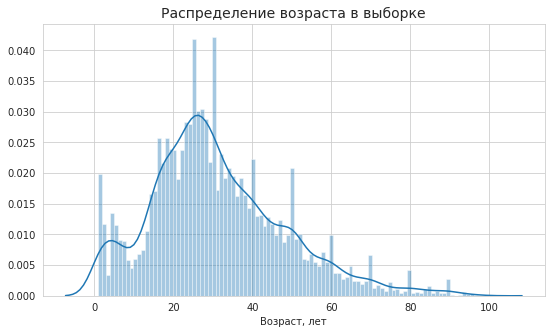

In [4]:
plt.figure(figsize=(9,5))
sns.distplot(labels['real_age'], bins=100)
plt.title('Распределение возраста в выборке', size=14)
plt.xlabel('Возраст, лет');

Выборка содержит информацию о фотографиях людей от 1 года до 100 лет.  
Большая часть людей на изображениях в возрасте 20-30 лет c пиками 25 и 30 лет, пики также есть у возрастов 40, 50, 60, 70, 80, 90 лет.  

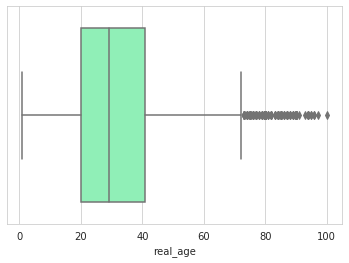

In [5]:
sns.boxplot(x="real_age", data=labels, palette='rainbow')

В выборке есть выбросы, а максимальный возраст равен 100 лет, что маловероятно, но возможно.  
Выбросы удалять не будем, т.к. на работу нейронной сети они не повлияют. 

**Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет**

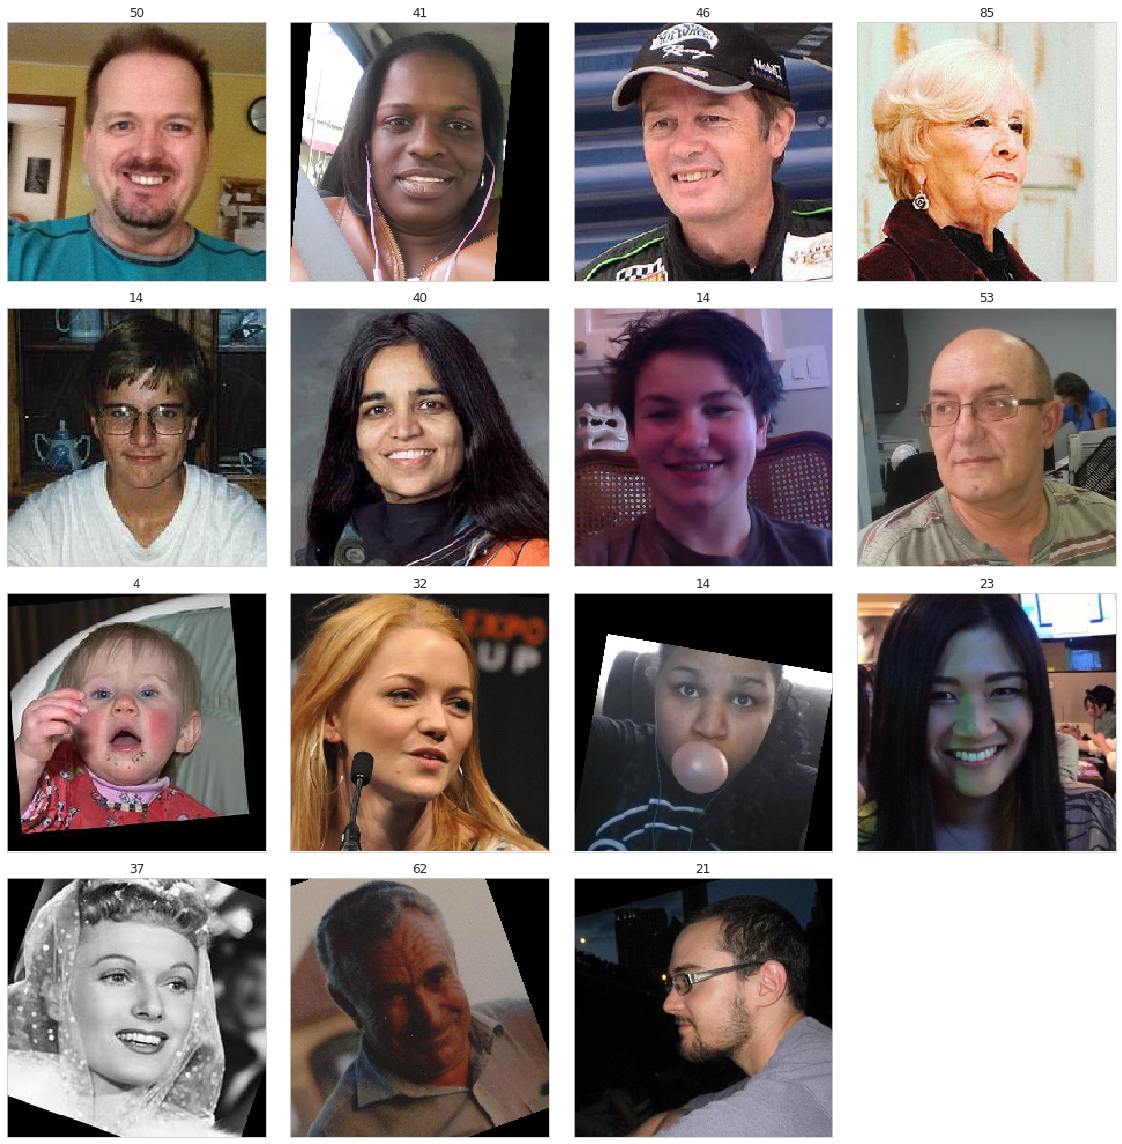

In [6]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(16,16))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()

В целом, возраст корректный. В стоке присутствуют люди разных рас, разного возраста, черно-белые фотографии.  
Модель должна обучиться корректно.

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                      horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr = 0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 190 steps, validate for 48 steps
Epoch 1/5
190/190 - 51s - loss: 261.4301 - mae: 11.7462 - val_loss: 998.1534 - val_mae: 19.7453
Epoch 2/5
190/190 - 42s - loss: 106.6755 - mae: 7.7468 - val_loss: 752.8719 - val_mae: 17.1727
Epoch 3/5
190/190 - 42s - loss: 79.6733 - mae: 6.7860 - val_loss: 199.4746 - val_mae: 9.7599
Epoch 4/5
190/190 - 42s - loss: 62.1981 - mae: 5.9942 - val_loss: 122.9442 - val_mae: 7.5892
Epoch 5/5
190/190 - 42s - loss: 55.8182 - mae: 5.6348 - val_loss: 101.4023 - val_mae: 6.7402

48/48 - 8s - loss: 101.4023 - mae: 6.7402
Test MAE: 6.7402

```

# 3. Анализ обученной модели

Мы обучили модель со следующими параметрами:
* архитектура ResNet50;
* optimizer ADAM с learning rate 0.0001;
* метрика качества - MAE;
* в выходном слое 1 нейрон, без активации;
* пять эпох;
* для улучшения качества модели применялась аугментация - вертикальный и горизонтальный поворот.  

В итоге обучения модели, на тестовой выборке был получен результат MAE = 6.7402, который соответсвует поставленной цели в задаче.  

Результат на тренировочной выборке 5.63, это означает, что модель немного переобучилась, но это является стандартным для нейронных сетей.